# Iris Data Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Getting-Started)
3. [Generating Syntethic Data](#Conditional-Generative-Adversarial-Network)
4. [Syntethic VS Real](#Quality-assessment)
5. [Conclusion](#Conclusion)

## Libraries

In [31]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis, iqr, entropy

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader

import torchmetrics

import random
from tqdm.auto import tqdm

In [32]:
def set_seed(seed = 0):
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Getting Started

In [33]:
X, y = load_iris()['data'], load_iris()['target']
features, species = load_iris()['feature_names'], load_iris()['target_names']

real_iris = pd.DataFrame(X, columns = features)
real_iris['target'] = y
real_iris['target'] = real_iris['target'].map({i: species[i] for i in range(len(species))})
real_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [53]:
def describe_data(data: pd.DataFrame, target_col: str):
    
    Mean = real_iris.groupby('target').mean().round(3)
    Std = real_iris.groupby('target').std().round(3)
    Min = real_iris.groupby('target').min().round(3)
    Max = real_iris.groupby('target').max().round(3)
    Skew = np.round([skew(data[data['target'] == label].iloc[:,:-1]) for label in data['target'].unique()],3)
    Kurt = np.round([kurtosis(data[data['target'] == label].iloc[:,:-1]) for label in data['target'].unique()],3)
    Iqr = np.round([[iqr(data[data['target'] == label][col]) for col in data.columns[:-1]]for label in data['target'].unique()], 3)
    
    stats = ['MEAN', 'STD', 'MIN', 'MAX', 'SKEW', 'KURT', 'IQR']
    indices_list = []
    for stat in stats:
        for i in range(len(data.columns[:-1])):
            indices_list.append((stat, features[i]))
            
    header = pd.MultiIndex.from_tuples(indices_list)
    array = np.hstack((Mean, Std, Min, Max, Skew, Kurt, Iqr))
    report = pd.DataFrame(array, columns = header, index = species).T
    
    return  report
        
describe_data(real_iris, 'target')

setosa  versicolor  virginica
MEAN sepal length (cm)   5.006       5.936      6.588
     sepal width (cm)    3.428       2.770      2.974
     petal length (cm)   1.462       4.260      5.552
     petal width (cm)    0.246       1.326      2.026
STD  sepal length (cm)   0.352       0.516      0.636
     sepal width (cm)    0.379       0.314      0.322
     petal length (cm)   0.174       0.470      0.552
     petal width (cm)    0.105       0.198      0.275
MIN  sepal length (cm)   4.300       4.900      4.900
     sepal width (cm)    2.300       2.000      2.200
     petal length (cm)   1.000       3.000      4.500
     petal width (cm)    0.100       1.000      1.400
MAX  sepal length (cm)   5.800       7.000      7.900
     sepal width (cm)    4.400       3.400      3.800
     petal length (cm)   1.900       5.100      6.900
     petal width (cm)    0.600       1.800      2.500
SKEW sepal length (cm)   0.116       0.102      0.114
     sepal width (cm)    0.040      -0.352      0.355
     petal length (cm)   0.103      -0.588      0.533
     petal width (cm)    1.216      -0.030     -0.126
KURT sepal length (cm)  -0.346      -0.599     -0.088
     sepal width (cm)    0.744      -0.448      0.520
     petal length (cm)   0.805      -0.074     -0.256
     petal width (cm)    1.434      -0.488     -0.661
IQR  sepal length (cm)   0.400       0.700      0.675
     sepal width (cm)    0.475       0.475      0.375
     petal length (cm)   0.175       0.600      0.775
     petal width (cm)    0.100       0.300      0.500

In [44]:
df = real_iris.select_dtypes('number') + np.random.normal(0, 1, (150,4))
df['target'] = real_iris['target']
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,4.794327,3.148951,1.977907,1.405671,setosa
1,3.171497,4.107887,0.416674,-0.651567,setosa
2,5.993342,1.956582,1.975530,-0.427367,setosa
3,3.596404,2.158419,1.374088,-1.140932,setosa
4,4.071027,4.402678,0.601442,-0.449925,setosa


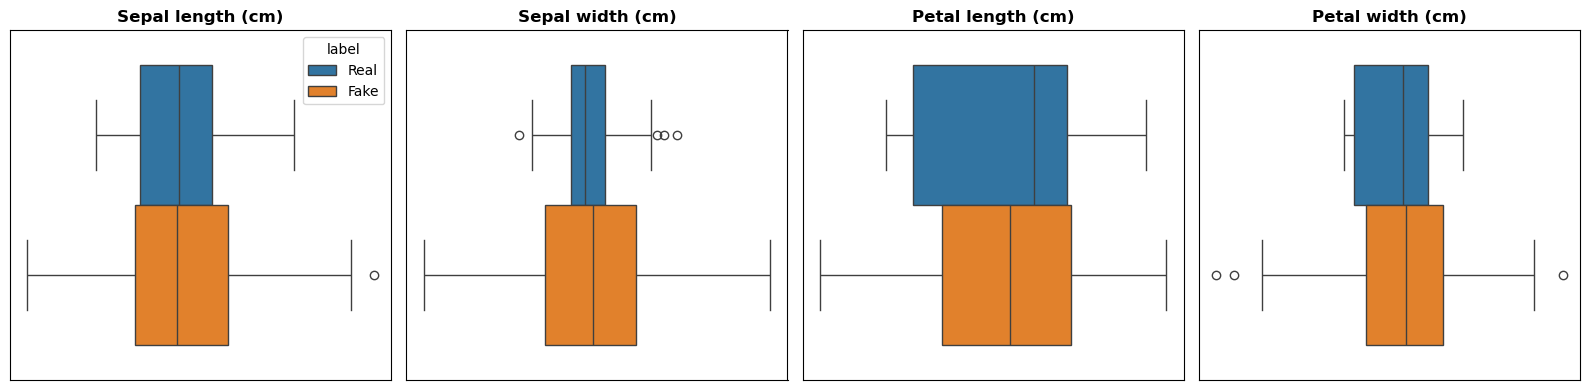

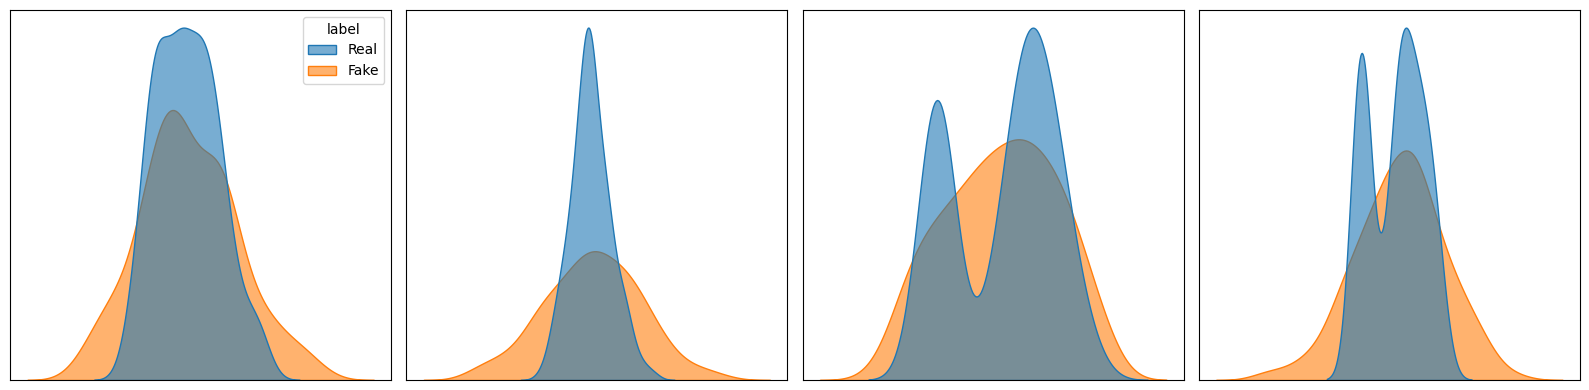

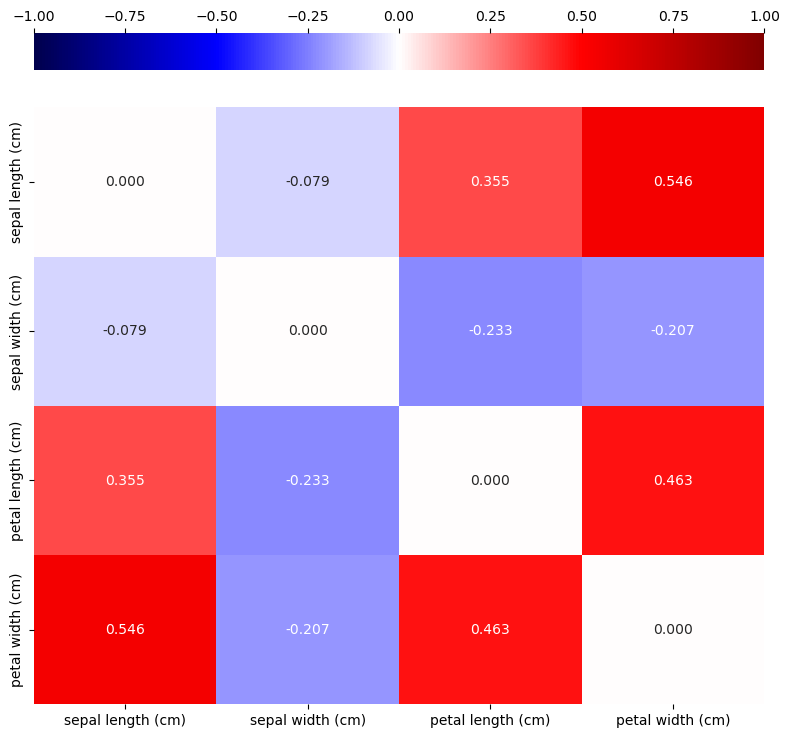

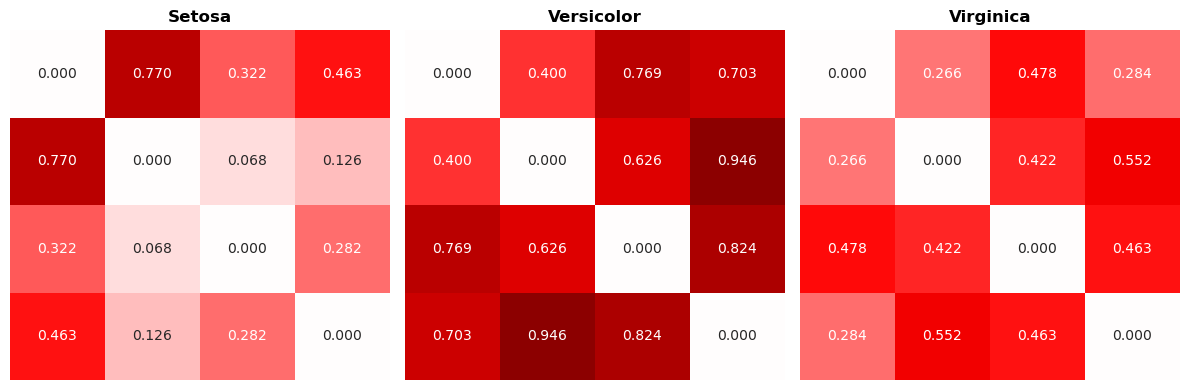

In [38]:
def plot_data(data1: pd.DataFrame, class_var: str, data2: pd.DataFrame = None):
    
    '''
    Plot the distributions and characteristics of the data.
    If only one dataset is provided it plots the characteristics of the data; 
    if two are provided it shows the differences between and characteristics of the two datasets.
    
    Args:
    data1: real data dataset
    target: pd.Series used to plot characteristics within classes
    data2: fake or generated data dataset
    '''
    
    if data2 is None:
        fig, ax = plt.subplots(1, len(data1.select_dtypes('number').columns), figsize = (16, 4))
        for idx, feature in enumerate(data1.select_dtypes('number').columns):
            sns.boxplot(data = data1, x = feature, hue = class_var, ax = ax[idx])
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            ax[idx].set_xlabel('')
            ax[idx].set_title(data1.select_dtypes('number').columns[idx].capitalize(), weight = 'bold')
            if idx != 0:
                ax[idx].legend().remove()    
        plt.tight_layout();
        
        fig, ax = plt.subplots(1, len(data1.select_dtypes('number').columns), figsize = (16, 4))
        for idx, feature in enumerate(data1.select_dtypes('number').columns):
            sns.kdeplot(data = data1, x = feature, hue = class_var, fill = True, alpha = 0.6, label = class_var, ax = ax[idx])
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            ax[idx].set_xlabel('')
            ax[idx].set_ylabel('')
            if idx != 0:
                ax[idx].legend().remove()    
        plt.tight_layout();
        
        plt.figure(figsize = (8, 8))
        sns.heatmap(data = data1.select_dtypes('number').corr(), cmap = 'seismic', vmin = -1, vmax = 1, annot = True, fmt = '.3f', cbar_kws = {'location':'top'})
        plt.tight_layout();
        
        fig, ax = plt.subplots(1, data1[class_var].nunique(), figsize = (12, 4))
        for idx, target in enumerate(data1[class_var].unique()):
            sns.heatmap(data = data1[data1[class_var] == target].select_dtypes('number').corr(), cmap = 'seismic', vmin = -1, vmax = 1, annot = True, fmt = '.3f', cbar = False, ax = ax[idx])
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            ax[idx].set_xlabel('')
            ax[idx].set_ylabel('')
            ax[idx].set_title(target.capitalize(), weight = 'bold')
        plt.tight_layout();
        
        
    else:
        
        data1 = data1.copy()
        data2 = data2.copy()
        data1['label'] = 'Real'
        data2['label'] = 'Fake'
        combined_data = pd.concat([data1, data2], ignore_index = True)
        
        fig, ax = plt.subplots(1, len(combined_data.select_dtypes('number').columns), figsize = (16, 4))
        for idx, feature in enumerate(combined_data.select_dtypes('number').columns):
            sns.boxplot(data = combined_data, x = feature, hue = 'label', ax = ax[idx])
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            ax[idx].set_xlabel('')
            ax[idx].set_title(combined_data.select_dtypes('number').columns[idx].capitalize(), weight = 'bold')
            if idx != 0:
                ax[idx].legend().remove()    
        plt.tight_layout();
        
        fig, ax = plt.subplots(1, len(combined_data.select_dtypes('number').columns), figsize = (16, 4))
        for idx, feature in enumerate(combined_data.select_dtypes('number').columns):
            sns.kdeplot(data = combined_data, x = feature, hue = 'label', fill = True, alpha = 0.6, label = 'label', ax = ax[idx])
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            ax[idx].set_xlabel('')
            ax[idx].set_ylabel('')
            if idx != 0:
                ax[idx].legend().remove()    
        plt.tight_layout();
        
        data1corr = combined_data[combined_data['label'] == 'Real'].select_dtypes('number').corr()
        data2corr = combined_data[combined_data['label'] == 'Fake'].select_dtypes('number').corr()
        plt.figure(figsize = (8, 8))
        sns.heatmap(data = (data1corr - data2corr), cmap = 'seismic', vmin = -1, vmax = 1, annot = True, fmt = '.3f', cbar_kws = {'location':'top'})
        plt.tight_layout();
        
        fig, ax = plt.subplots(1, combined_data[class_var].nunique(), figsize = (12, 4))
        for idx, target in enumerate(combined_data[class_var].unique()):
            
            real_corr_data = combined_data[(combined_data['target'] == target) & (combined_data['label'] == 'Real')].select_dtypes('number').corr()
            fake_corr_data = combined_data[(combined_data['target'] == target) & (combined_data['label'] == 'Fake')].select_dtypes('number').corr()
            
            sns.heatmap(data = (real_corr_data - fake_corr_data), cmap = 'seismic', vmin = -1, vmax = 1, annot = True, fmt = '.3f', cbar = False, ax = ax[idx])
            ax[idx].set_xticks([])
            ax[idx].set_yticks([])
            ax[idx].set_xlabel('')
            ax[idx].set_ylabel('')
            ax[idx].set_title(target.capitalize(), weight = 'bold')
        plt.tight_layout();
            
            
            
plot_data(data1 = real_iris, class_var = 'target', data2 = df)